In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import optuna

In [22]:
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)
df = df.reset_index().rename(columns={'index': 'ds'})

In [23]:
target = 'btc_log_return'
regresores_externos = ['eth_log_return', 'sp500_log_return', 'gold_log_return', 'dxy_log_return']

lags = [1, 2, 3]

# 3. Crear lags del retorno
for lag in lags:
    df[f'lag_{lag}'] = df[target].shift(lag)

# 4. Seleccionar columnas de entrada y salida
features = [f'lag_{lag}' for lag in lags] + regresores_externos
df_model = df[['ds', target] + features].dropna().copy()

# 5. Separar en entrenamiento y prueba (80/20)
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [5]:
def transform_log(data, y_test, y_pred):
    P0 = data.loc[test.index[0], 'btc_close']
    
    log_price_real = np.exp(np.cumsum(y_test))
    log_price_pred = np.exp(np.cumsum(y_pred))
    
    price_real = P0 * log_price_real
    price_pred = P0 * log_price_pred
    
    mae = mean_absolute_error(price_real, price_pred)
    rmse_price = np.sqrt(mean_squared_error(price_real, price_pred))
    
    return price_real, price_pred, mae, rmse_price

In [6]:
def plot(price_real, price_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(test['ds'], price_real, label='Precio real (reconstruido)', color='blue')
    plt.plot(test['ds'], price_pred, label='Precio predicho (XGBoost)', color='orange')
    plt.fill_between(test['ds'], price_real, price_pred, color='gray', alpha=0.3, label='Error')
    plt.title('Predicción vs Real – Precio BTC (reconstruido desde retornos)')
    plt.xlabel('Fecha')
    plt.ylabel('Precio (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📊 MAE:  7137.664938
📊 RMSE: 9486.267817


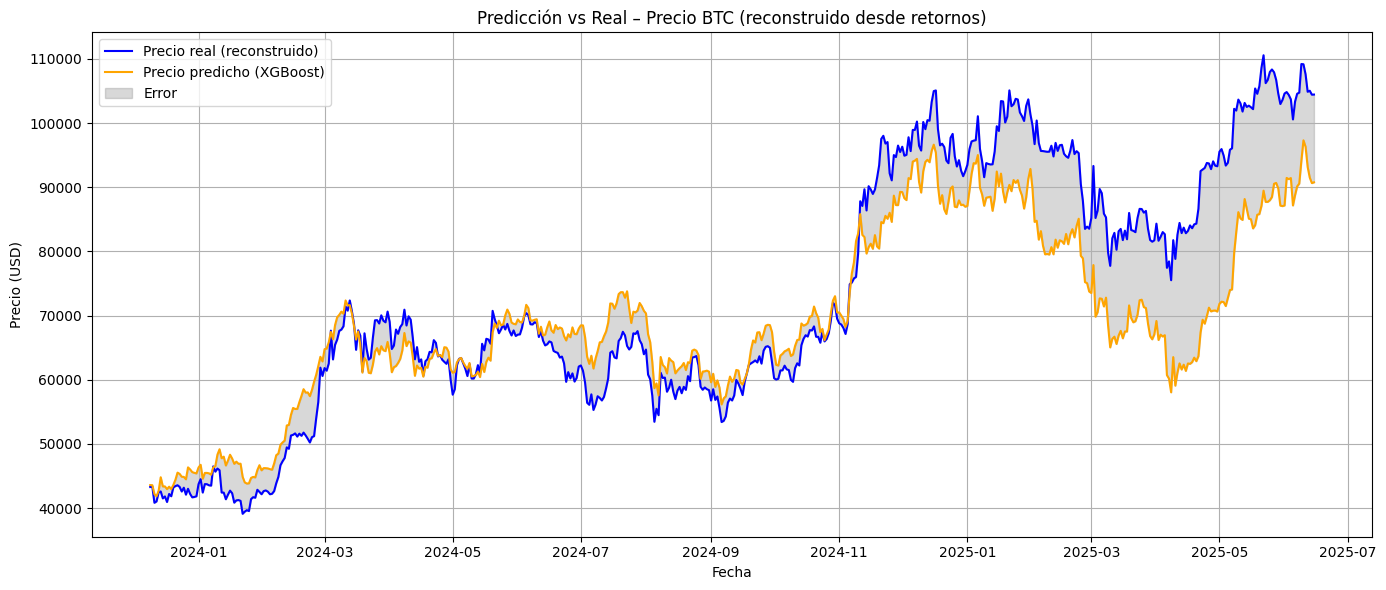

In [26]:
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

price_real, price_pred, mae, rmse = transform_log(df, y_test, y_pred)

print(f"📊 MAE:  {mae:.6f}")
print(f"📊 RMSE: {rmse:.6f}")

plot(price_real, price_pred)

In [27]:
importancias = model.feature_importances_
features = model.get_booster().feature_names

df_importancia = pd.DataFrame({
    'feature': features,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Mostrar top 10
print(df_importancia.head(10))

            feature  importance
3    eth_log_return    0.695371
4  sp500_log_return    0.079133
5   gold_log_return    0.062367
0             lag_1    0.044084
6    dxy_log_return    0.041938
1             lag_2    0.038827
2             lag_3    0.038280


In [9]:
def objective(trial):
    # Sugerencia de hiperparámetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42
    }

    # Entrenamiento
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    _, _, _, rmse = transform_log(df, y_test, y_pred)

    return rmse

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("🔍 Mejor combinación de hiperparámetros:")
print(study.best_params)
print(f"📊 Mejor RMSE en escala de precio: {study.best_value:.2f} USD")


[I 2025-06-15 23:32:09,237] A new study created in memory with name: no-name-ba566723-f54b-4b22-8f10-194ec7a90058
[I 2025-06-15 23:32:09,289] Trial 0 finished with value: 22761.676727679373 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.18410712497849646, 'subsample': 0.6070468216344374, 'colsample_bytree': 0.9308672585368141, 'gamma': 3.2233385015754705}. Best is trial 0 with value: 22761.676727679373.
[I 2025-06-15 23:32:09,344] Trial 1 finished with value: 21603.85628975392 and parameters: {'n_estimators': 264, 'max_depth': 6, 'learning_rate': 0.15824518099041576, 'subsample': 0.9153692032394247, 'colsample_bytree': 0.7094773800310782, 'gamma': 3.6869015207026887}. Best is trial 1 with value: 21603.85628975392.
[I 2025-06-15 23:32:09,396] Trial 2 finished with value: 19533.88983824731 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.14229740221080006, 'subsample': 0.9741257652180798, 'colsample_bytree': 0.9703075752375054, 'gamma': 0

🔍 Mejor combinación de hiperparámetros:
{'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.2220497018162848, 'subsample': 0.9953654199347161, 'colsample_bytree': 0.8784901510145754, 'gamma': 0.024058813066319962}
📊 Mejor RMSE en escala de precio: 8506.68 USD


📊 MAE:  6558.357472
📊 RMSE: 8506.681915


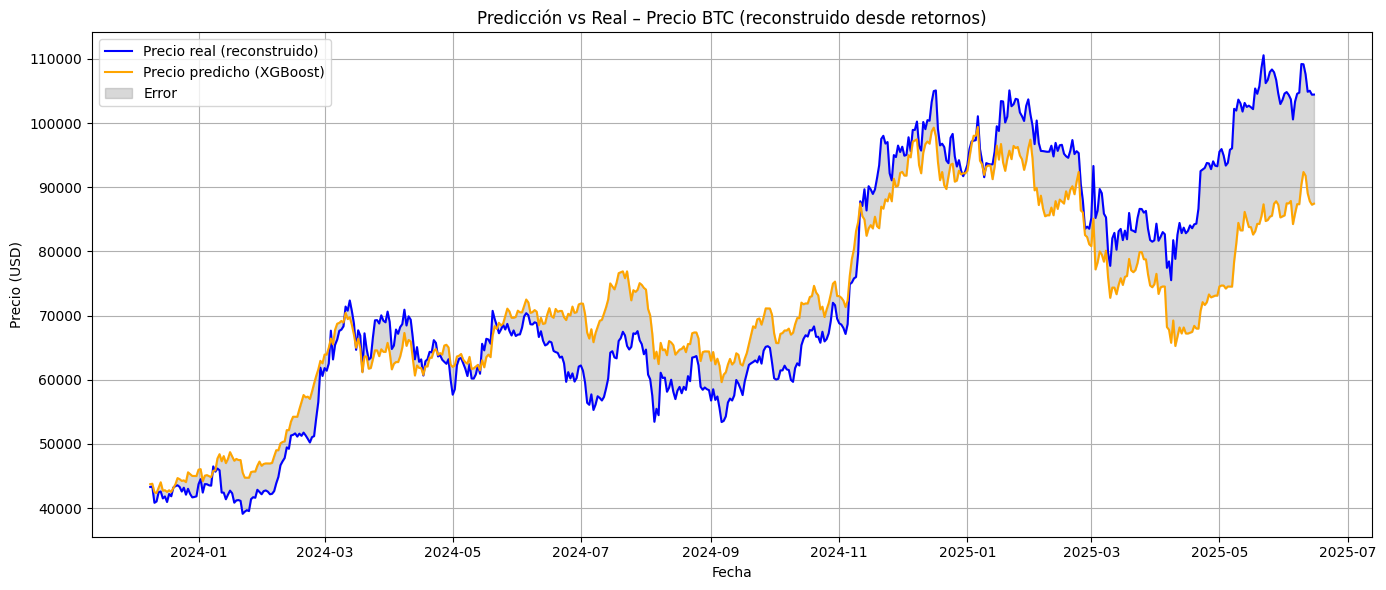

In [32]:
# Hiperparámetros óptimos
best_params = {
    'n_estimators': 75,
    'max_depth': 6,
    'learning_rate': 0.2220497018162848,
    'subsample': 0.9953654199347161,
    'colsample_bytree': 0.8784901510145754,
    'gamma': 0.024058813066319962,
    'random_state': 42
}

# Instanciar el modelo
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

price_real, price_pred, mae, rmse = transform_log(df, y_test, y_pred)

print(f"📊 MAE:  {mae:.6f}")
print(f"📊 RMSE: {rmse:.6f}")
plot(price_real, price_pred)

In [ ]:
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)
df = df.reset_index().rename(columns={'index': 'ds'})

target = 'btc_log_return'

lags = [1, 2, 3]

for lag in lags:
    df[f'lag_{lag}'] = df[target].shift(lag)

features = [f'lag_{lag}' for lag in lags]
df_model = df[['ds', target] + features].dropna().copy()

train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [10]:
# Ejecutar estudio
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Mostrar mejor resultado
print("🔍 Mejor combinación de hiperparámetros:")
print(study.best_params)
print(f"📊 Mejor RMSE en escala de precio: {study.best_value:.2f} USD")

[I 2025-06-16 13:17:00,889] A new study created in memory with name: no-name-a785a5e2-c869-485b-92b5-02379e688a79
[I 2025-06-16 13:17:00,931] Trial 0 finished with value: 14696.451566595222 and parameters: {'n_estimators': 135, 'max_depth': 2, 'learning_rate': 0.13352803578252867, 'subsample': 0.8714332879575934, 'colsample_bytree': 0.942867250129328, 'gamma': 3.0403484564937138}. Best is trial 0 with value: 14696.451566595222.
[I 2025-06-16 13:17:00,961] Trial 1 finished with value: 16010.547544185758 and parameters: {'n_estimators': 126, 'max_depth': 3, 'learning_rate': 0.2387382122051218, 'subsample': 0.9879838590798645, 'colsample_bytree': 0.9408211659767028, 'gamma': 4.434589560326497}. Best is trial 0 with value: 14696.451566595222.
[I 2025-06-16 13:17:00,978] Trial 2 finished with value: 20618.008504109344 and parameters: {'n_estimators': 52, 'max_depth': 7, 'learning_rate': 0.15386600427414482, 'subsample': 0.63191775196064, 'colsample_bytree': 0.6932236162030336, 'gamma': 3.84

🔍 Mejor combinación de hiperparámetros:
{'n_estimators': 116, 'max_depth': 2, 'learning_rate': 0.15476536257440474, 'subsample': 0.7422230714613174, 'colsample_bytree': 0.8222861875265084, 'gamma': 2.051735710190279}
📊 Mejor RMSE en escala de precio: 13524.59 USD


📊 MAE:  9943.315595
📊 RMSE: 13524.591484


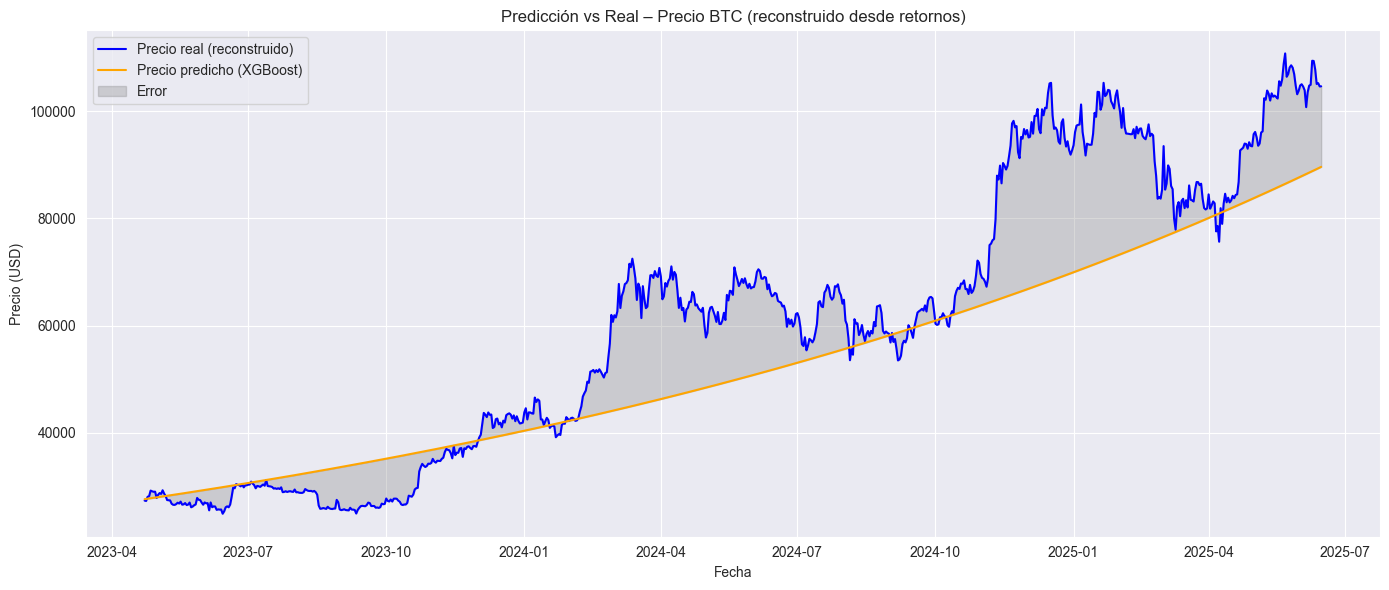

In [11]:
# Hiperparámetros óptimos
best_params = {
    'n_estimators': 116,
    'max_depth': 2,
    'learning_rate': 0.15476536257440474,
    'subsample': 0.7422230714613174,
    'colsample_bytree': 0.8222861875265084,
    'gamma': 2.051735710190279,
    'random_state': 42
}

# Instanciar el modelo
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

price_real, price_pred, mae, rmse = transform_log(df, y_test, y_pred)

print(f"📊 MAE:  {mae:.6f}")
print(f"📊 RMSE: {rmse:.6f}")
plot(price_real, price_pred)